<a href="https://colab.research.google.com/github/rajanpawar90/TensorFlow-in-Practice-Deeplearning.ai-/blob/master/SummaryCode/Course4_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Install TensorFlow 2 version




In [0]:
 #Install the latest version of tensorflow
 !pip install --upgrade tensorflow

In [0]:
import tensorflow as tf
print("tensorflow version is",tf.__version__)
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [0]:
#Functions to plot and simulate timeseries
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return slope*time

def seasonal_pattern(season_time):
  return np.where(season_time< 0.1,
                  np.cos(season_time * 7 * np.pi),
                  1/np.exp(5*season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time= ((time + phase) % period) / period 
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.01
noise_level = 2

#createa the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
#update with noise
series += noise(time, noise_level, seed=42)

#example of a time series with noise
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [12]:
#Download Sunspots data for this workbook
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-12-29 02:35:50--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2019-12-29 02:35:50 (140 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



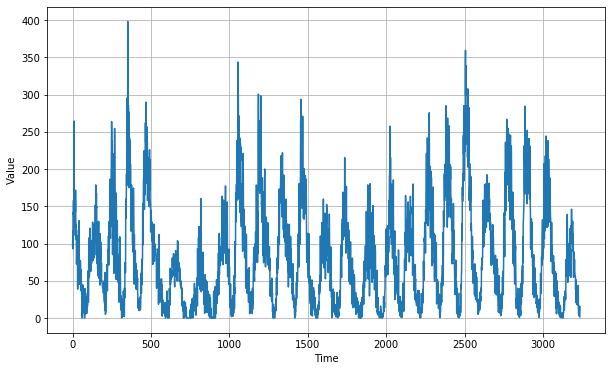

In [21]:
#open downloaded csv and generate series/values vs time plots
import csv
time_steps = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile , delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_steps.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_steps)
plt.figure(figsize = (10, 6))
plot_series(time, series)


In [0]:
#use Dataset class to create source data from input data (https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=nightly).  
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1) 

In [0]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(batch_size).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [0]:
#Create train and validation datasets
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [75]:
#Create NN model using ConvD, LSTM, Dense, lambda layers 
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)    #train_set X and Y values
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, 
                         kernel_size=5, 
                         strides=1, 
                         padding='causal', 
                         activation='relu', 
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences = True),           #'Bidrectional is optional
  tf.keras.layers.LSTM(64, return_sequences = True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20)) 
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(), 
              optimizer = optimizer,
              metrics = ['mae'])                                                             #Alternatively, loss = 'mse' for mean squared error ; metrics = ['acc']

history = model.fit(train_set, epochs = 50, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/50
12/12 [==============================] - 8s 702ms/step - loss: 80.3072 - mae: 80.3315
Epoch 2/50
12/12 [==============================] - 5s 441ms/step - loss: 77.9405 - mae: 78.5896
Epoch 3/50
12/12 [==============================] - 5s 441ms/step - loss: 75.2415 - mae: 75.9445
Epoch 4/50
12/12 [==============================] - 5s 436ms/step - loss: 72.2421 - mae: 72.7693
Epoch 5/50
12/12 [==============================] - 5s 440ms/step - loss: 68.5302 - mae: 69.2661
Epoch 6/50
12/12 [==============================] - 5s 437ms/step - loss: 64.8655 - mae: 65.6140
Epoch 7/50
12/12 [==============================] - 5s 433ms/step - loss: 61.1551 - mae: 62.0189
Epoch 8/50
12/12 [==============================] - 5s 434ms/step - loss: 58.2311 - mae: 58.6465
Epoch 9/50
12/12 [==============================] - 5s 437ms/step - loss: 54.7059 - mae: 55.5682
Epoch 10/50
12/12 [======

[1e-08, 0.0001, 0, 60]

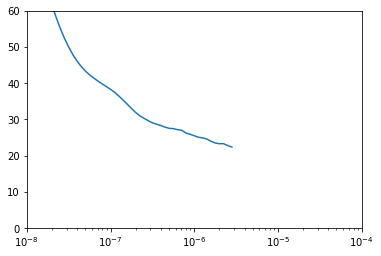

In [76]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

Mean squared error is 17.48729


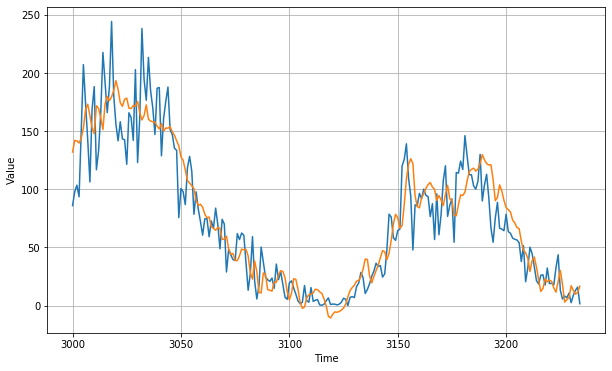

In [77]:
#Run and plot prediction
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size: -1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
print("Mean squared error is",tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

<Figure size 432x288 with 0 Axes>

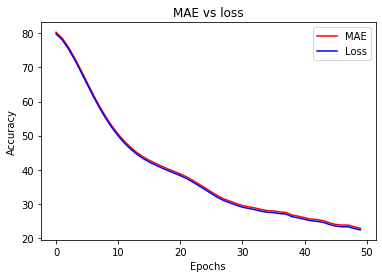

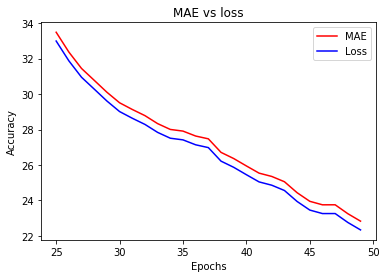

<Figure size 432x288 with 0 Axes>

In [79]:
#Plot epochs vs mean squared error
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

mae = history.history['mae']
loss = history.history['loss']
epochs = range(len(loss)) #get no of epochs

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE vs loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])
plt.figure() #print plot

#plot zomed mae and loss
epochs_zoom = epochs[25:]
mae_zoom = mae[25:]
loss_zoom = loss[25:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE vs loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])
plt.figure() #print plot

#Naive Forecast 

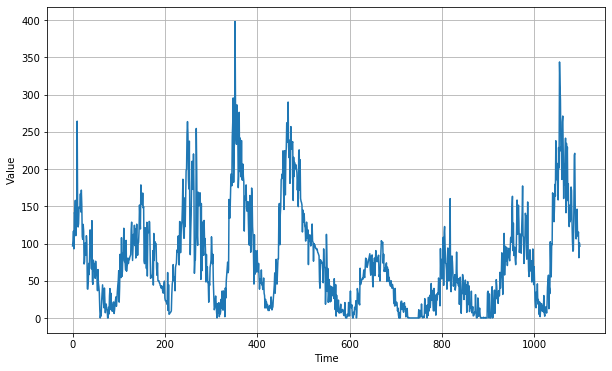

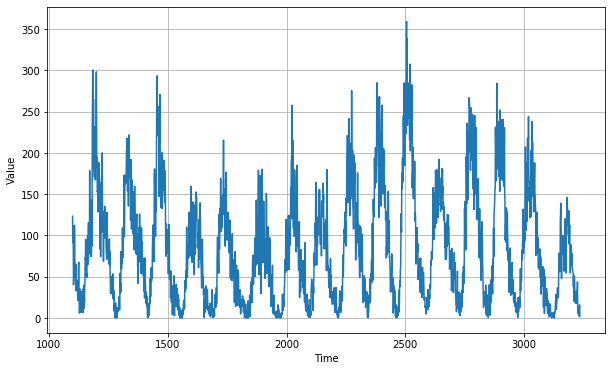

In [81]:
#split train and validation data
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

#zoomed view
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

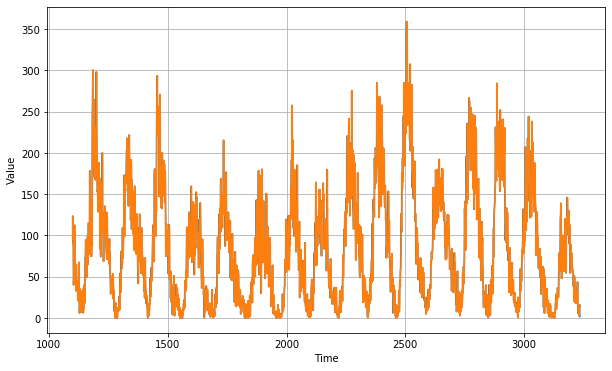

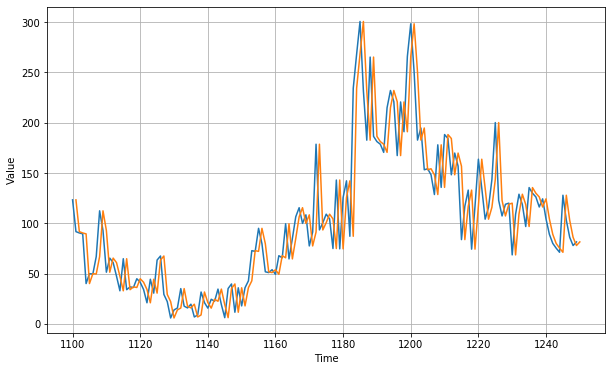

In [82]:
#Generate naive forecast
naive_forecast = series[split_time - 1:-1]

#plot forecasts vs actuals
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

#zoom in plots
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [84]:
#mean squared and mean absolute error
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

736.1976393442621
19.52805620608899


2595.181304059329
39.77498985167837


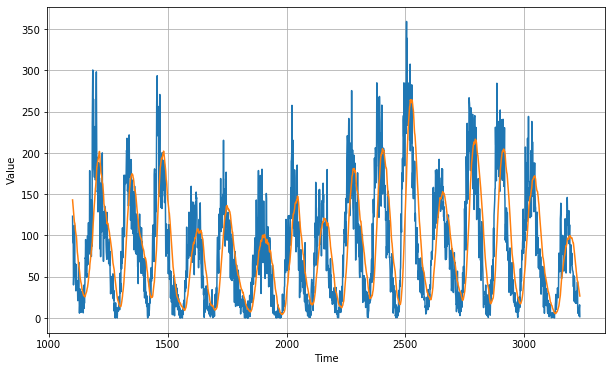

In [89]:
#Moving averages
def moving_averages_forecast(series, window_size):
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

moving_avg  = moving_averages_forecast(series, 30)[split_time - 30:]
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

plt.figure(figsize = (10, 6))
plot_series(time_valid , x_valid)
plot_series(time_valid , moving_avg)

That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time t – 365 from the value at time t. Use code below to capture seasonality

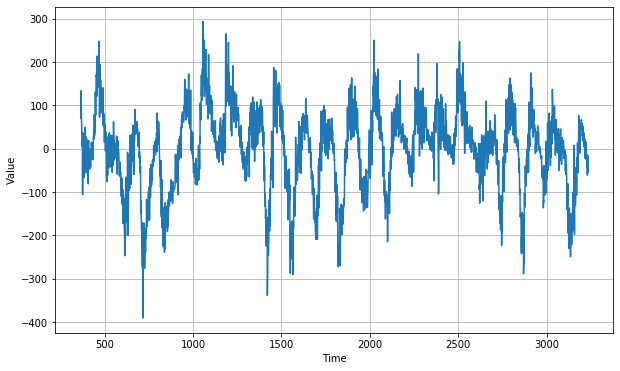

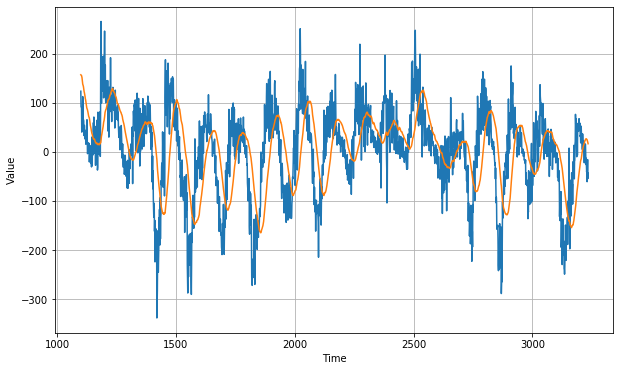

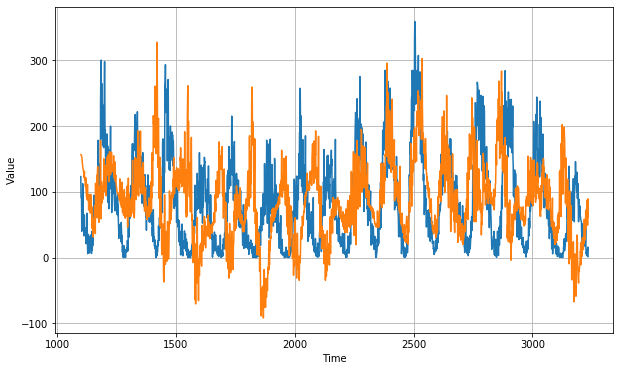

7116.937704916158
66.8229067915691


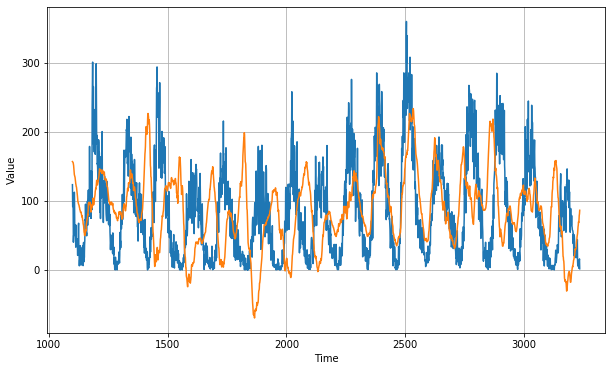

6489.953882902109
64.47083372365339


In [91]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

#Great, the trend and seasonality seem to be gone, so now we can use the moving average:
diff_moving_avg = moving_averages_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

#Now let's bring back the trend and seasonality by adding the past values from t – 365:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

#Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:
diff_moving_avg_plus_smooth_past = moving_averages_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())